# Sports Analytics Final Project (Group 4)

- Dataset: https://www.kaggle.com/pschale/mlb-pitch-data-20152018/notebooks

# Notebook Part I: Data Cleaning and Exploration

In [1]:
import pandas as pd 
import numpy as np
pd.options.mode.chained_assignment = None

In [2]:
# load the datasets
atbats = pd.read_csv("atbats.csv")
#games = pd.read_csv('games.csv')
pitches = pd.read_csv('pitches.csv')

In [3]:
player_list = pd.read_csv('player_names.csv')

## Filtering for 2018 data just for initial analysis:

In [4]:
atbats['year'] = atbats['ab_id']//1e6
pitches['year'] = pitches['ab_id']//1e6

In [5]:
atbats_2018 = atbats[atbats['year']==2018]
pitches_2018 = pitches[pitches['year']==2018]
atbats_2018.to_csv('atbats_2018')
pitches_2018.to_csv('pitches_2018')

In [6]:
pitches_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 724444 entries, 2142710 to 2867153
Data columns (total 41 columns):
px                 718322 non-null float64
pz                 718322 non-null float64
start_speed        718334 non-null float64
end_speed          718334 non-null float64
spin_rate          718322 non-null float64
spin_dir           718322 non-null float64
break_angle        718322 non-null float64
break_length       718322 non-null float64
break_y            718322 non-null float64
ax                 718322 non-null float64
ay                 718322 non-null float64
az                 718322 non-null float64
sz_bot             723353 non-null float64
sz_top             723353 non-null float64
type_confidence    718322 non-null float64
vx0                718322 non-null float64
vy0                718322 non-null float64
vz0                718322 non-null float64
x                  724444 non-null float64
x0                 718322 non-null float64
y                  724

## 2018 Data: 

In [7]:
atbats_2018 = pd.read_csv('atbats_2018')

In [8]:
event_dict = {'Single': '1B','Double': '2B','Triple': '3B','Home Run': 'HR','Walk': 'BB',
            'Intent Walk': 'IBB','Hit By Pitch': 'HBP','Strikeout': 'K','Sac Fly': 'SF',
            'Grounded Into DP': 'GIDP','Groundout': 'GO','Lineout': 'LO','Pop Out': 'PO',
            'Flyout': 'FO','Fielders Choice': 'FC','Sac Bunt': 'SAC','Double Play': 'DP',
            'Triple Play': 'TP','Batter Interference': 'BI','Fan interference': 'FI',
            'Catcher Interference': 'CI','Field Error': 'ROE','Bunt Groundout': 'BGO',
            'Bunt Lineout': 'BLO','Bunt Pop Out': 'BPO','Fielders Choice Out': 'FCO',
            'Forceout': 'FORCE','Sacrifice Bunt DP': 'SBDP','Strikeout - DP': 'KDP',
            'Runner Out': 'RO','Sac Fly DP': 'SFDP'
           }
# most of the code in these two cells were provided by the author: because the dataset contains raw pitch-by-pitch outcomes, 
# there is a need to make certain aggregations and transformations to get meaningful statistics. For example, we see that 
# whether or not we have an 'atbat' excludes the situations where we have a sacrifice fly, a walk, a hit-by-pitch, etc.

In [9]:
atbats_2018['event'] = atbats_2018['event'].apply(lambda x: event_dict[x]) 
eventcol = atbats_2018['event']
atbats_2018 = pd.get_dummies(atbats_2018, columns=['event'], prefix='')
atbats_2018['event'] = eventcol

atbats_2018['_H'] = atbats_2018[['_1B', '_2B', '_3B', '_HR']].sum(axis=1) #TOTAL HITS
atbats_2018['_TB'] = atbats_2018['_1B'] + 2*atbats_2018['_2B'] + 3*atbats_2018['_3B'] + 4*atbats_2018['_HR'] #TOTAL BASES
atbats_2018['_K'] = atbats_2018['_K'] + atbats_2018['_KDP'] #TOTAL STRIKEOUTS
atbats_2018['_BB'] = atbats_2018['_BB'] + atbats_2018['_IBB'] #WALKS AND INTENTIONAL WALKS
atbats_2018['_AB'] = 1 - atbats_2018[['_CI', '_SAC', '_BB', 
                            '_HBP', '_RO', '_SF']].sum(axis=1) #AT BATS
atbats_2018['_PA'] = 1 - atbats_2018['_RO'] #PLATE APPEARANCE

atbats_2018['_outs'] = atbats_2018['o'] - atbats_2018.groupby(['g_id', 
                                                'inning', 
                                                'top'])['o'].shift(1).fillna(0) #
atbats_2018['IP'] = atbats_2018.groupby('pitcher_id')['_outs'].transform(pd.Series.cumsum) / 3

In [10]:
atbats_2018.columns

Index(['Unnamed: 0', 'ab_id', 'batter_id', 'g_id', 'inning', 'o', 'p_score',
       'p_throws', 'pitcher_id', 'stand', 'top', 'year', '_1B', '_2B', '_3B',
       '_BB', '_BGO', '_BI', '_BLO', '_BPO', '_CI', '_DP', '_FC', '_FCO',
       '_FO', '_FORCE', '_GIDP', '_GO', '_HBP', '_HR', '_IBB', '_K', '_KDP',
       '_LO', '_PO', '_RO', '_ROE', '_SAC', '_SBDP', '_SF', '_SFDP', '_TP',
       'event', '_H', '_TB', '_AB', '_PA', '_outs', 'IP'],
      dtype='object')

### Pitchers ranked by batting stats:

In [11]:
atbats_2018.head()

,Unnamed: 0,ab_id,batter_id,g_id,inning,o,p_score,p_throws,pitcher_id,stand,...,_SF,_SFDP,_TP,event,_H,_TB,_AB,_PA,_outs,IP
0,554815,2018000001,446359,201800001,1,1,0,R,608665,R,...,0,0,0,K,0,0,1,1,1.0,0.333333
1,554816,2018000002,545361,201800001,1,2,0,R,608665,R,...,0,0,0,GO,0,0,1,1,1.0,0.666667
2,554817,2018000003,457708,201800001,1,3,0,R,608665,R,...,0,0,0,PO,0,0,1,1,1.0,1.000000
3,554818,2018000004,459964,201800001,1,0,0,R,572070,L,...,0,0,0,1B,1,1,1,1,0.0,0.000000
4,554819,2018000005,543760,201800001,1,0,0,R,572070,R,...,0,0,0,1B,1,1,1,1,0.0,0.000000


In [12]:
lefty_ids = atbats_2018[atbats_2018.p_throws=='L']['pitcher_id'].unique()
righty_ids = atbats_2018[atbats_2018.p_throws=='R']['pitcher_id'].unique()
#we find the identifiers for our left and right handed pitches for easire filtering later on 

In [13]:
min_IP = atbats_2018.groupby('pitcher_id')['IP'].max() > 50
#we want a boolean series to filter out only pitchers who have thrown at least 50 innings pitched 

In [14]:
pitchers_list = player_list[player_list['id'].isin(atbats_2018.pitcher_id)]
pitchers_list.set_index('id',inplace=True)

In [15]:
len(atbats_2018.pitcher_id.unique()) #we have 799 unique pitchers

799

In [16]:
handedness = atbats_2018.groupby('pitcher_id')[['p_throws','pitcher_id']].tail(n=1).set_index('pitcher_id')

In [17]:
pitchers_list = pitchers_list.join(handedness)

In [18]:
pitchers_list.to_csv('pitchers_list')

In the next section, we calculate some aggregate pitching performance metrics to compare the performance between lefties and righties. The result is that, while there are differences, they seem to be fairly marginal. We focus on 4 statistics here: 

- Batting Average Against (BAA): This tells us how often a pitcher gives up a hit in terms of the batting average that opposing batters have against him. 
- Strikeouts per 9 Innings,(K/9): This tells us how many batters the pitcher strikes out on average over 9 innings. 
- Fielding Independent Pitching (FIP): This is an increasingly popular sabermetric value that tries to measure in the same units as Earned Run Average, but focuses only on the outcomes that a pitcher can control, thus it is independent of defence. This includes things like homeruns, walks and strikeouts. 
- Walks Hits per Innings Pitched (WHIP): This tells us in general how often batters can get on base versus a pitcher in each inning. 

### Batting Average Against

In [19]:
pitcher_avgs = atbats_2018.groupby('pitcher_id').apply(lambda x: x['_H'].sum()/x['_AB'].sum())
pitcher_avgs = pd.merge(pitchers_list, pd.DataFrame(pitcher_avgs, columns=['BAA']), left_index=True, right_index=True)
#calculate batting average against a pitcher. the lower the better.

C:\Users\Isaac Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in longlong_scalars
  """Entry point for launching an IPython kernel.


In [20]:
pitcher_avgs[min_IP].sort_values('BAA').head(15)

#among pitchers with 25 IP, there are our top 15 batters in terms of BAA
#corroborated against 2018 stats, blake snell .178 and scherzer .188

C:\Users\Isaac Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,first_name,last_name,p_throws,BAA
600917,Jose,Leclerc,R,0.125654
623352,Josh,Hader,L,0.132353
547973,Aroldis,Chapman,L,0.135593
518886,Craig,Kimbrel,R,0.145540
606625,Reyes,Moronta,R,0.153846
622554,Seranthony,Dominguez,R,0.156863
493603,Adam,Ottavino,R,0.157692
595014,Blake,Treinen,R,0.158076
621242,Edwin,Diaz,R,0.159533
543521,Collin,McHugh,R,0.176471


In [21]:
LR_aggregate = pd.DataFrame({'L':pitcher_avgs.loc[lefty_ids][min_IP].mean(),'R':pitcher_avgs.loc[righty_ids][min_IP].mean()})
LR_aggregate
#we use this to work towards constructing a dataframe with all our useful statistics comparing lefties and righties

C:\Users\Isaac Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,L,R
BAA,0.242697,0.239857


## K/9 Innings:

In [22]:
pitcher_K9 = atbats_2018.groupby('pitcher_id').apply(lambda x: x['_K'].sum()/(x['IP'].max()/9))
pitcher_K9 = pd.merge(pitchers_list, pd.DataFrame(pitcher_K9, columns=['K9']), left_index=True, right_index=True)
pitcher_K9[min_IP].sort_values('K9', ascending=False).head(15)
#calculate strikeouts per 9 for each pitcher.

C:\Users\Isaac Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
C:\Users\Isaac Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,first_name,last_name,p_throws,K9
547973,Aroldis,Chapman,L,16.305195
623352,Josh,Hader,L,15.823770
476454,Dellin,Betances,R,15.525000
621242,Edwin,Diaz,R,15.218182
608349,Corey,Knebel,R,14.313253
598264,Matt,Barnes,R,14.010811
518886,Craig,Kimbrel,R,13.860963
519242,Chris,Sale,L,13.500000
502748,Brad,Peacock,R,13.292308
543272,Brad,Hand,L,13.250000


In [23]:
LR_aggregate = pd.concat([LR_aggregate, pd.DataFrame({'L':pitcher_K9.loc[lefty_ids][min_IP].mean(),'R':pitcher_K9.loc[righty_ids][min_IP].mean()})]) 
LR_aggregate

C:\Users\Isaac Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,L,R
BAA,0.242697,0.239857
K9,8.677162,8.713415


## Fielding Independent Pitching

In [24]:
pitcher_FIP = atbats_2018.groupby('pitcher_id').apply(lambda x: (13*x['_HR'].sum()+3*x['_BB'].sum()+x['_HBP'].sum()-2.0*x['_K'].sum())/x['IP'].max()+3.22)
pitcher_FIP = pd.merge(pitchers_list, pd.DataFrame(pitcher_FIP, columns=['FIP']), left_index=True, right_index=True)
pitcher_FIP[min_IP].sort_values('FIP', ascending=True).head(15)

C:\Users\Isaac Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.
C:\Users\Isaac Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,first_name,last_name,p_throws,FIP
621242,Edwin,Diaz,R,1.501818
595014,Blake,Treinen,R,1.850705
519242,Chris,Sale,L,1.859241
600917,Jose,Leclerc,R,1.884740
547973,Aroldis,Chapman,L,1.953766
594798,Jacob,deGrom,R,1.998802
519293,Will,Smith,L,2.125660
489334,Craig,Stammen,R,2.169367
623352,Josh,Hader,L,2.260984
621237,Jose,Alvarado,L,2.298125


In [25]:
LR_aggregate = pd.concat([LR_aggregate, pd.DataFrame({'L':pitcher_FIP.loc[lefty_ids][min_IP].mean(),'R':pitcher_FIP.loc[righty_ids][min_IP].mean()})]) 
LR_aggregate

C:\Users\Isaac Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,L,R
BAA,0.242697,0.239857
K9,8.677162,8.713415
FIP,3.904079,3.985036


## Walks and Hits per Innings Pitched (WHIP)

In [26]:
pitcher_WHIP = atbats_2018.groupby('pitcher_id').apply(lambda x: (x['_BB'].sum()+x['_H'].sum())/x['IP'].max())
pitcher_WHIP = pd.merge(pitchers_list, pd.DataFrame(pitcher_WHIP, columns=['WHIP']), left_index=True, right_index=True)
pitcher_WHIP[min_IP].sort_values('WHIP', ascending=True).head(15)

C:\Users\Isaac Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
C:\Users\Isaac Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,first_name,last_name,p_throws,WHIP
621242,Edwin,Diaz,R,0.790909
623352,Josh,Hader,L,0.811475
595014,Blake,Treinen,R,0.834025
600917,Jose,Leclerc,R,0.849711
519242,Chris,Sale,L,0.860759
434378,Justin,Verlander,R,0.901869
453286,Max,Scherzer,R,0.910876
594798,Jacob,deGrom,R,0.912442
543521,Collin,McHugh,R,0.912442
489446,Kirby,Yates,R,0.920635


In [27]:
LR_aggregate = pd.concat([LR_aggregate, pd.DataFrame({'L':pitcher_WHIP.loc[lefty_ids][min_IP].mean(),'R':pitcher_WHIP.loc[righty_ids][min_IP].mean()})]) 
LR_aggregate

C:\Users\Isaac Lim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,L,R
BAA,0.242697,0.239857
K9,8.677162,8.713415
FIP,3.904079,3.985036
WHIP,1.285686,1.260045


Can we draw any conclusions about the performance of left and right handers this season? Well, not exactly given that they are fairly similar - it would appear that on an aggregate level, LHPs and RHPs are able to limit batters to the same number of hits and runs while striking them out at a similar rate. There seems to be a difference in the FIP value, however we note that a difference of 0.08 is still rather small. We analyze these differences further in the code.

## Exploring the Platoon Advantage:

So one oft-cited reason for having left-handers is that they have a platoon advantage against left-handed batters. In general, batters fare worse against pitchers who are of the same hand, so the logic goes that teams employ left-handers to get left-handed batters out. We investigate this in two ways: first, we checked to see if the platoon advantage does indeed exist, and second, we checked to see if left-handers were indeed deployed disproportionately against left-handed batters, confirming the platoon advantage as a reason for left-handers being sought after.

### Characterizing pitch quality between left and right handed batters

Glossary: https://fastballs.wordpress.com/2007/08/02/glossary-of-the-gameday-pitch-fields/

In [28]:
pitches_2018.dropna(inplace=True)

In [29]:
pitches_2018['code'].unique()

array(['C', 'B', 'F', 'S', 'T', 'X', 'D', '*B', 'E', 'W', 'H', 'L', 'M',
       'P', 'Q', 'V', 'R'], dtype=object)

In [30]:
pitches_2018['pitch_type'].unique()

array(['SI', 'SL', 'FF', 'FC', 'CU', 'CH', 'FT', 'FS', 'KC', 'EP', 'FO',
       'PO', 'SC', 'KN', 'AB'], dtype=object)

In [31]:
relevant_pitches = ['SI', 'SL', 'FF', 'FC', 'CU', 'CH', 'FT', 'FS', 'KC']
pitch_dict = {'SI':'Sinker', 
              'SL':'Slider', 
              'FF':'4-Seam Fastball', 
              'FC':'Cutter', 
              'CU':'Curveball', 
              'CH':'Change-up', 
              'FT':'2-Seam Fastball' , 
              'FS':'Splitter', 
              'KC':'Knuckle Curve'}

In [32]:
pitches_2018 = pitches_2018[pitches_2018['pitch_type'].isin(relevant_pitches)]
pitches_2018['pitch_type'] = pitches_2018['pitch_type'].apply(lambda x: pitch_dict[x])
#the pitches include other less common pitches like the eephus pitch, knuckle ball, pitch-outs, etc. 
# We remove these and focus only on the most common pitches. 

A note about standardization:
In the data, horizontal movement is measured by pfx_x and vertical movement is measured by pfx_z. This gives us a sense of how much a breaking-pitch moves during its flight. 

When a right hander throws a slider, the ball breaks towards his left, while when a left hander throws a slider, it breaks to his right. This tells us that for the same pitch, the movement is inverted for left and right handers. To have a valid comparison between the two, we therefore need to look at their absolute movement. However, we also note that taking the absolute value of movement for pitches obscures other features. For example for a right hander, his slider would break left and hence have positive values for pfx_x, but his 2-seam fastball would break right, having negative values. Calculating the absolute value of pitch movements would obscure this difference in direction. Hence, we take the negative values for movement if a pitcher is left-handed to invert their pitching movement to the same orientation as right-handers.

In [33]:
df = pitches_2018.merge(atbats_2018[['ab_id','pitcher_id']], on='ab_id').join(pitchers_list, on = 'pitcher_id')
pitch_qualities = ['start_speed', 'spin_rate', 'break_angle', 'pfx_x', 'pfx_z', 'pitch_type','p_throws']
df = df[pitch_qualities]
df['pfx_x'] = df.apply(lambda x: -x['pfx_x'] if x['p_throws'] == 'L' else x['pfx_x'], axis=1)
df['break_angle'] = df.apply(lambda x: -x['break_angle'] if x['p_throws'] == 'L' else x['break_angle'], axis=1)

In [34]:
#higher prevalence of left handed pitchers in baseball than in the general population (25% vs 10%)
pitchers_list['p_throws'].value_counts()/len(pitchers_list)

R    0.742178
L    0.257822
Name: p_throws, dtype: float64

In [35]:
df.groupby(['pitch_type','p_throws']).mean()
#here we look at the average velocity, spin_rate, break angle and movement of pitches by lefties and righties

start_speed    spin_rate  break_angle     pfx_x  \
pitch_type      p_throws                                                    
2-Seam Fastball L           91.016580  2053.397747    31.032512 -8.443629   
                R           93.039273  2171.105692    34.401718 -8.724895   
4-Seam Fastball L           92.243591  2100.911444    24.380482 -5.055384   
                R           93.492785  2103.426330    24.265219 -4.707828   
Change-up       L           83.263122  1776.668811    23.732636 -8.476321   
                R           84.713838  1700.143655    22.879304 -7.957612   
Curveball       L           76.723534  1192.275530    -8.535280  4.365374   
                R           79.035691  1268.085825    -9.755467  4.750553   
Cutter          L           87.368854   973.740864    -3.047743  0.233648   
                R           89.339412  1052.609924    -5.476308  0.842028   
Knuckle Curve   L           79.618885   862.211572    -4.693834  1.984771   
                R           81.286732  1309.628808    -8.510987  3.945319   
Sinker          L           91.329291  2131.582999    31.851260 -8.779017   
                R           91.745366  2070.284181    31.182606 -9.110671   
Slider          L           83.117205   737.104903    -7.544137  2.416350   
                R           84.809335   727.104510    -7.845674  2.423010   
Splitter        L           83.863003  1505.296560    19.976426 -7.347289   
                R           85.280235  1365.661832    17.949133 -6.347442   

                             pfx_z  
pitch_type      p_throws            
2-Seam Fastball L         5.855799  
                R         6.173368  
4-Seam Fastball L         9.014234  
                R         9.098860  
Change-up       L         4.488098  
                R         3.980337  
Curveball       L        -5.218231  
                R        -4.958307  
Cutter          L         4.766796  
                R         4.977691  
Knuckle Curve   L        -4.154981  
                R        -6.051857  
Sinker          L         5.542114  
                R         4.239377  
Slider          L         1.047404  
                R         1.228757  
Splitter        L         2.950074  
                R         2.857380

In [36]:
#here we calculate the difference in pitch qualities between RHP and LHP (i.e. +ve value indicates RHP throws harder, etc)
df.groupby(['pitch_type','p_throws']).mean().groupby('pitch_type').diff(1).groupby('pitch_type').tail(n=1)

,,start_speed,spin_rate,break_angle,pfx_x,pfx_z
pitch_type,p_throws,,,,,
2-Seam Fastball,R,2.022693,117.707944,3.369207,-0.281265,0.317570
4-Seam Fastball,R,1.249195,2.514886,-0.115263,0.347556,0.084626
Change-up,R,1.450717,-76.525156,-0.853331,0.518708,-0.507762
Curveball,R,2.312157,75.810295,-1.220188,0.385179,0.259924
Cutter,R,1.970558,78.869061,-2.428565,0.608380,0.210895
Knuckle Curve,R,1.667847,447.417236,-3.817153,1.960548,-1.896876
Sinker,R,0.416074,-61.298817,-0.668653,-0.331654,-1.302737
Slider,R,1.692129,-10.000393,-0.301538,0.006660,0.181353
Splitter,R,1.417232,-139.634729,-2.027293,0.999848,-0.092694


### T-Testing the Difference in Pitch Quality:

To ensure that these differences are statistically significant, we use a t-test to drawn our conclusions.

In [37]:
def t_test(array1, array2):
    from scipy.stats import norm
    N1 = len(array1)
    N2 = len(array2)
    mu1 = array1.mean()
    mu2 = array2.mean()
    sd1 = np.std(array1)
    sd2 = np.std(array2)
    se = sd1/np.sqrt(N1) + sd2/np.sqrt(N2)
    t = (mu1-mu2)/se
    p = 1 - norm.cdf(t)
    return p

In [38]:
def test_pitches(df, pitch_type):
    right = df[(df['p_throws']=='R') & (df['pitch_type']==pitch_type)]
    left = df[(df['p_throws']=='L') & (df['pitch_type']==pitch_type)]
    
    variables = ['start_speed', 'spin_rate', 'pfx_x', 'pfx_z']
    
    p_value_matrix = np.ones((2,len(variables)))
    
    for col, variable in enumerate(variables): 
        array1 = right[variable]
        array2 = left[variable]
        
        p_value_matrix[0, col] = round(t_test(array1, array2) , 4)
        p_value_matrix[1, col] = round(t_test(array2, array1) , 4)

    return pd.DataFrame(p_value_matrix, columns=variables, index=['R>L','L>R'])      

In [39]:
pitch_types = ['Sinker', 'Slider', '4-Seam Fastball', 'Cutter', 'Curveball', 'Change-up', '2-Seam Fastball', 'Splitter']

test_pitch_df = pd.concat([test_pitches(df,pitch_types[0])], keys=[pitch_types[0]], names=['Pitch Type'])

for pitch in pitch_types[1:]:
    result = test_pitches(df,pitch)
    result = pd.concat([result], keys=[pitch], names=['Pitch Type'])
    test_pitch_df = pd.concat([test_pitch_df, result ], axis=0)

In [40]:
def color_vals(val):
    color = 'red' if val<0.05 else 'black'
    return 'color: %s' % color
test_pitch_df.style.applymap(color_vals)

The table above contains the p-values for the respective t-tests for each pitch type and the corresponding condition. For example in the first row it is the test that the average values for the right handers are greater than the left handers, and the next row is the test that the values for the left handers are greater than the right handers. These two are symmetrical. 

We see here that, across the board, right handers throw faster than left-handers. They also feature more spin and break on several pitches. This affirms to us that, in general, right handers seem to have pitchers of objectively higher quality.

### Is the Platoon Advantage True? Do LHPs perform better against LHBs than RHBs?

In [41]:
def OPS(x):
    OBP = (x['_H']+x['_BB']+x['_HBP']).sum()/(x['_AB']+x['_BB']+x['_HBP']+x['_SF']).sum()
    SLG = x['_TB'].sum()/x['_AB'].sum()
    return OBP+SLG

def BA(x):
    return x['_H'].sum()/x['_AB'].sum()

In [42]:
pd.concat([atbats_2018.groupby(['p_throws','stand'])['_K','_BB'].mean().round(3),
           pd.DataFrame(atbats_2018.groupby(['p_throws','stand']).apply(OPS), columns=['OPS']),
           pd.DataFrame(atbats_2018.groupby(['p_throws','stand']).apply(BA), columns=['Batting Average'])], axis=1).round(3)

_K    _BB    OPS  Batting Average
p_throws stand                                      
L        L      0.241  0.079  0.668            0.234
         R      0.216  0.089  0.740            0.253
R        L      0.212  0.098  0.753            0.251
         R      0.230  0.072  0.711            0.246

It does appear that some form of the platoon advantage exists - batters facing pitchers on the same side have a lower OPS and for LHPs this also applied to batting average. In terms of strikeouts and walks, we see this trend as well: batters of the opposite side struckout less and walked more. The question to ask then, is how often are left-handed pitchers used to get right-handed batters out, and vice-versa. 

In [43]:
pd.DataFrame(atbats_2018.groupby(['p_throws','stand']).size()/atbats_2018.groupby(['p_throws']).size(),
             columns=['% of ABs against L/R Batter'])

% of ABs against L/R Batter
p_throws stand                             
L        L                         0.276203
         R                         0.723797
R        L                         0.465094
         R                         0.534906

While LHPs do indeed fare better against LHBs, it seems implausible that they are hired in teams just to be used against LHBs. We see from the frequencies that LHPs only face LHB's 28% of the time, a lower frequency than RHPs face LHBs. This suggests to us that there are many situations where LHPs are not able to use their platoon advantage, since they may not even be substituted in to face LHBs. 

# Notebook Part II: Visualization and Modelling

In [44]:
atbats_2018 = pd.read_csv('atbats_2018')
atbats_2018.drop('Unnamed: 0', inplace=True, axis=1)
pitches_2018 = pd.read_csv('pitches_2018')
pitches_2018.drop('Unnamed: 0', inplace=True, axis=1)
pitchers_list = pd.read_csv('pitchers_list')

event_dict = {'Single': '1B','Double': '2B','Triple': '3B','Home Run': 'HR','Walk': 'BB',
            'Intent Walk': 'IBB','Hit By Pitch': 'HBP','Strikeout': 'K','Sac Fly': 'SF',
            'Grounded Into DP': 'GIDP','Groundout': 'GO','Lineout': 'LO','Pop Out': 'PO',
            'Flyout': 'FO','Fielders Choice': 'FC','Sac Bunt': 'SAC','Double Play': 'DP',
            'Triple Play': 'TP','Batter Interference': 'BI','Fan interference': 'FI',
            'Catcher Interference': 'CI','Field Error': 'ROE','Bunt Groundout': 'BGO',
            'Bunt Lineout': 'BLO','Bunt Pop Out': 'BPO','Fielders Choice Out': 'FCO',
            'Forceout': 'FORCE','Sacrifice Bunt DP': 'SBDP','Strikeout - DP': 'KDP',
            'Runner Out': 'RO','Sac Fly DP': 'SFDP'
           }
atbats_2018['event'] = atbats_2018['event'].apply(lambda x: event_dict[x]) 
eventcol = atbats_2018['event']
atbats_2018 = pd.get_dummies(atbats_2018, columns=['event'], prefix='')
atbats_2018['event'] = eventcol

atbats_2018['_H'] = atbats_2018[['_1B', '_2B', '_3B', '_HR']].sum(axis=1) #TOTAL HITS
atbats_2018['_TB'] = atbats_2018['_1B'] + 2*atbats_2018['_2B'] + 3*atbats_2018['_3B'] + 4*atbats_2018['_HR'] #TOTAL BASES
atbats_2018['_K'] = atbats_2018['_K'] + atbats_2018['_KDP'] #TOTAL STRIKEOUTS
atbats_2018['_BB'] = atbats_2018['_BB'] + atbats_2018['_IBB'] #WALKS AND INTENTIONAL WALKS
atbats_2018['_AB'] = 1 - atbats_2018[['_CI', '_SAC', '_BB', 
                            '_HBP', '_RO', '_SF']].sum(axis=1) #AT BATS
atbats_2018['_PA'] = 1 - atbats_2018['_RO'] #PLATE APPEARANCE

atbats_2018['_outs'] = atbats_2018['o'] - atbats_2018.groupby(['g_id', 
                                                'inning', 
                                                'top'])['o'].shift(1).fillna(0) #
atbats_2018['IP'] = atbats_2018.groupby('pitcher_id')['_outs'].transform(pd.Series.cumsum) / 3


relevant_pitches = ['SI', 'SL', 'FF', 'FC', 'CU', 'CH', 'FT', 'FS']
pitch_dict = {'SI':'Sinker', 
              'SL':'Slider', 
              'FF':'4-Seam Fastball', 
              'FC':'Cutter', 
              'CU':'Curveball', 
              'CH':'Change-up', 
              'FT':'2-Seam Fastball' , 
              'FS':'Splitter', 
              }
pitches_2018 = pitches_2018[pitches_2018['pitch_type'].isin(relevant_pitches)]
pitches_2018['pitch_type'] = pitches_2018['pitch_type'].apply(lambda x: pitch_dict[x])

In [45]:
pitches_atbats = pitches_2018.merge(atbats_2018, on='ab_id')
pitches_atbats = pitches_atbats.merge(pitchers_list[['id','p_throws']], left_on='pitcher_id',right_on='id',how='left')
pitches_atbats.drop(['p_throws_y','id'], inplace=True, axis=1)
pitches_atbats.rename({'p_throws_x':'p_throws'}, inplace=True, axis=1)

Here we join the pitches and atbats data frames to create an aggregate dataframe that contains both pitch data (in terms of speed, movement, etc), and pitch outcomes (in terms of hits, walks, etc). 

# Visualizing Pitches:

In [46]:
from IPython.display import Image
Image(url= 'https://static01.nyt.com/images/2016/04/24/sports/24-DOG-DIGITAL-2/24-DOG-DIGITAL-2-articleLarge.jpg?quality=75&auto=webp&disable=upscale', 
      width=1200,height=1200)

Here we attempt to create meaningful visualizations about differences between left and right handed pitchers before we produce the expected bases model. In particular, we try to model the following graphic that is used by MLB, but across all pitches thrown in the season. We know that the strikezone has a width of 17-inches, and is generally speaking 2 inches in height, ranging from 1.5ft from the ground to 3.5ft from the ground. We use these approximate measurements to plot the strikezone. In our plots, we also include a grey perimeter around the strikezone equal to the half-width of a baseball, approximately 1.5 inches. This is to account for the reality that umpires generally call pitches that are around, but not in, the strikezone for strikes, particularly when we are late in the pitching count.

### Some notes about the variables: 

px: the left/right distance, in feet, of the pitch from the middle of the plate as it crossed home plate. The PITCHf/x coordinate system is oriented to the catcher’s perspective, with distances to the right being positive and to the left being negative.

pz: the height of the pitch in feet as it crossed the front of home plate.

type: a one-letter abbreviation for the result of the pitch: B, ball; S, strike (including fouls); X, in play.

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [48]:
def filter_pitches(df, pitch_type, handedness=None):
    df = df[df['pitch_type']== pitch_type]
    if handedness:
        df = df[df['p_throws']== handedness]
    return df    

def plot_strikezone(ax, df, strikes = 1, balls = 0, platewidth = 17/12, plateheight = 2, zonebottom = 1.5):
    ball = 3/12
    
    inner_zone = plt.Rectangle((platewidth/-2, zonebottom), width = platewidth, height = plateheight, alpha=0.3, color='navy')
    outer_zone = plt.Rectangle((platewidth/-2 - ball/2, zonebottom-ball/2), width = platewidth+ball, height = plateheight+ball, alpha=0.8, color='grey')

    ax.add_patch(outer_zone)
    ax.add_patch(inner_zone)

    ax.set_ylim(0,5)
    ax.set_xlim(-2,2)

    for x in np.linspace(zonebottom,zonebottom+plateheight,4):
        x1 = [platewidth/-2, platewidth/2]
        y1 = [x,x]
        ax.plot(x1,y1, color='black', linewidth=4)

    for x in np.linspace(platewidth/-2, platewidth/2,4):
        x1 = [x,x]
        y1 = [zonebottom,zonebottom+plateheight]
        ax.plot(x1,y1, color='black', linewidth= 4)

 
    if strikes: 
        strikes_df = df[df['type'].isin(['S'])]
        ax.plot(strikes_df['px'],strikes_df['pz'], 'bo', markersize=3, alpha=0.2)
        
   
    if balls: 
        balls_df = df[df['type'].isin(['B'])]
        ax.plot(balls_df['px'],balls_df['pz'], 'ro', markersize=3, marker='x', alpha=0.2)
    ax.set_aspect('equal')
    
    
    #return ax

In [49]:
strikes_balls = pitches_atbats[pitches_atbats['type'].isin(['S','B'])]

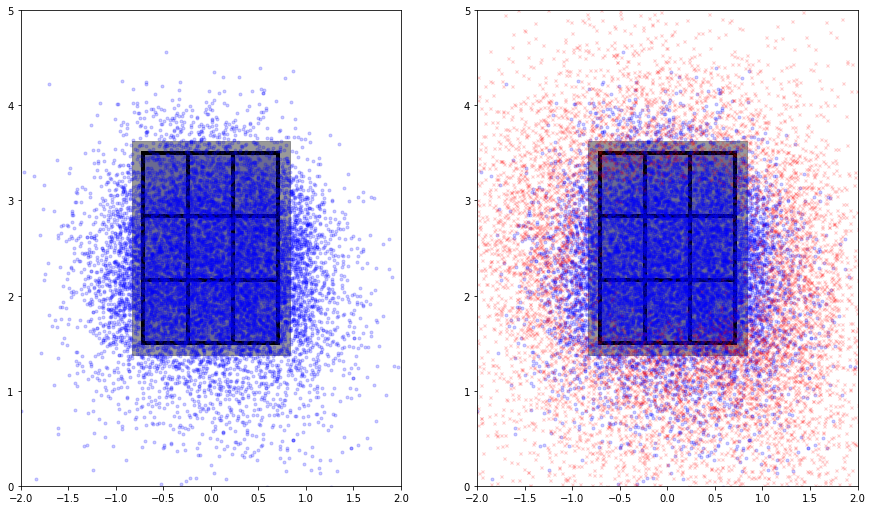

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
plot_strikezone(ax1, strikes_balls.iloc[1:20000,:])
plot_strikezone(ax2, strikes_balls.iloc[1:20000,:], balls = 1)
#we plot 20000 pitches here because having too many creates too saturated an image. But the large number already tells us 
#what we need about the distribution of pitches. In this case, we plot strikes and balls

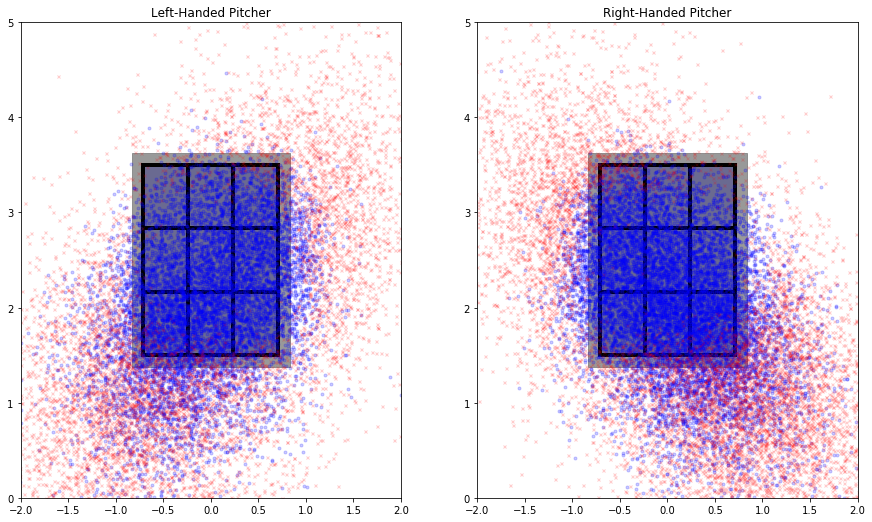

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
plot_strikezone(ax1, filter_pitches(strikes_balls, 'Curveball', handedness='L').iloc[:20000,], balls = 1)
plot_strikezone(ax2, filter_pitches(strikes_balls, 'Curveball', handedness='R').iloc[:20000,], balls = 1)
ax1.title.set_text('Left-Handed Pitcher')
ax2.title.set_text('Right-Handed Pitcher')
#here we plot curveballs for right and left handers.

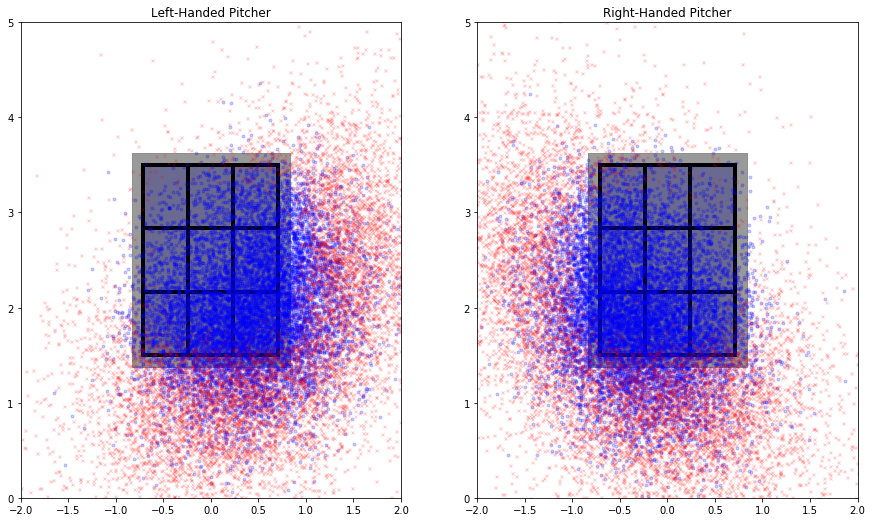

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
plot_strikezone(ax1, filter_pitches(strikes_balls, 'Change-up', handedness='L').iloc[:20000,], balls = 1)
plot_strikezone(ax2, filter_pitches(strikes_balls, 'Change-up', handedness='R').iloc[:20000,], balls = 1)
ax1.title.set_text('Left-Handed Pitcher')
ax2.title.set_text('Right-Handed Pitcher')
#here we plot changeups for right and left handers

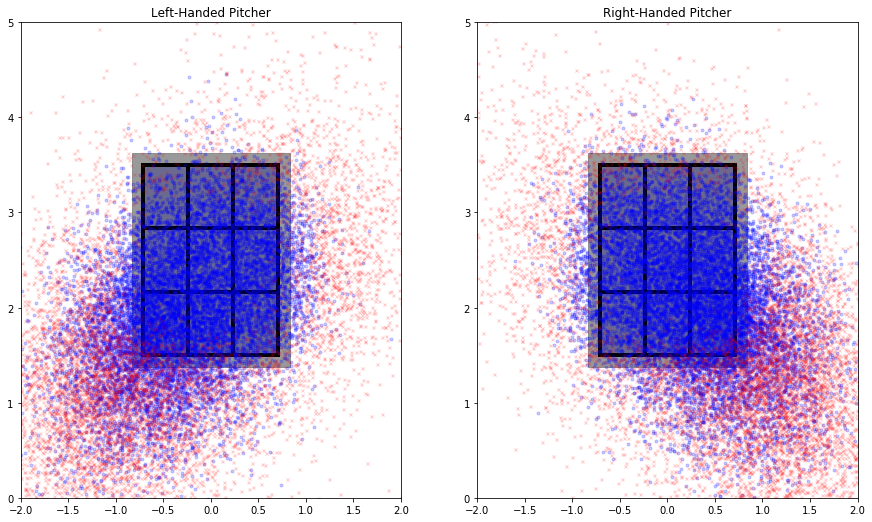

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
plot_strikezone(ax1, filter_pitches(strikes_balls, 'Slider', handedness='L').iloc[:20000,], balls = 1)
plot_strikezone(ax2, filter_pitches(strikes_balls, 'Slider', handedness='R').iloc[:20000,], balls = 1)
ax1.title.set_text('Left-Handed Pitcher')
ax2.title.set_text('Right-Handed Pitcher')

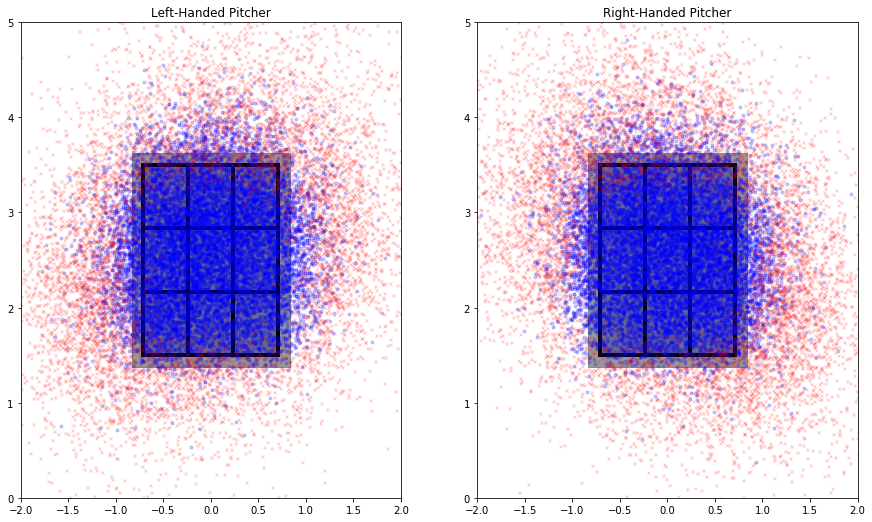

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
plot_strikezone(ax1, filter_pitches(strikes_balls, '4-Seam Fastball', handedness='L').iloc[:20000,], balls = 1)
plot_strikezone(ax2, filter_pitches(strikes_balls, '4-Seam Fastball', handedness='R').iloc[:20000,], balls = 1)
ax1.title.set_text('Left-Handed Pitcher')
ax2.title.set_text('Right-Handed Pitcher')
#here we plot fastballs for right and left handers

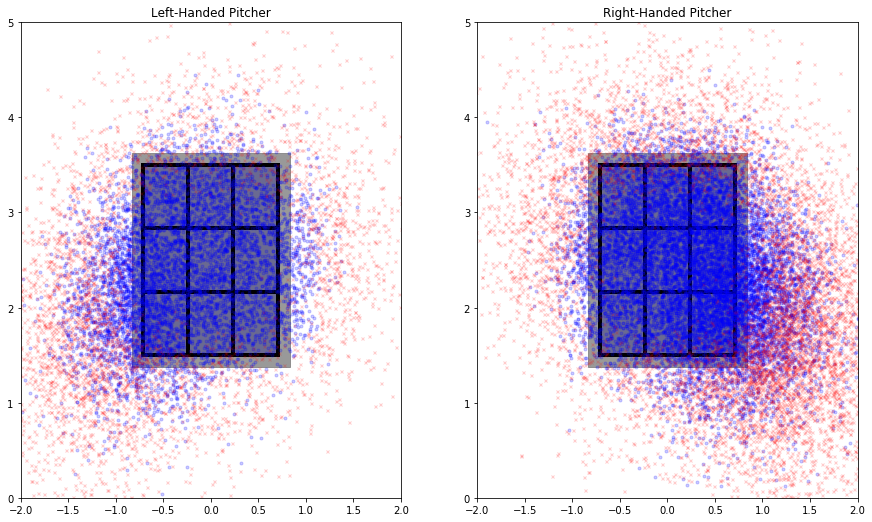

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
plot_strikezone(ax1, filter_pitches(strikes_balls, 'Cutter', handedness='L').iloc[:20000,], balls = 1)
plot_strikezone(ax2, filter_pitches(strikes_balls, 'Cutter', handedness='R').iloc[:20000,], balls = 1)
ax1.title.set_text('Left-Handed Pitcher')
ax2.title.set_text('Right-Handed Pitcher')
#here we plot cutters for right and left handers

### Creating a Strikezone Heatmap

The strikezone plots above give us a good visual idea of how different pitchers generate strikes at different parts of the strikezone, but they don't really tell us which types of pitches generate the most swings and misses at which part of the strike zone. To do so, we can look at the % of each pitch within each of the 9 parts of the strike zone that generate strikes/swings and misses, visualizing the result through a heatmap.

In [56]:
def plot_heatmap(df, ax, handedness=None, pitch=None, vmin=0.3, vmax=0.5,code=None):
    if not code:
        code = ['S','C','W']
        
    if handedness:
        df = df[df['p_throws']==handedness]
        
    if pitch:
        df = df[df['pitch_type']==pitch]
    zone_strike_pct = df.groupby('zone').apply(lambda x: x['code'].isin(code).sum()/len(x))
    zone_heatmap = np.array(zone_strike_pct).reshape(3,3)
    #fig, ax = plt.subplots(figsize=(5,5))
    #ax.set_aspect('equal')
    sns.heatmap(np.array(zone_strike_pct).reshape(3,3), ax = ax, annot=True, linewidths=0.5, cmap="Reds", vmin=vmin, vmax=vmax)
    
def strikezone_partition(row, platewidth = 17/12, plateheight = 2, zonebottom = 1.5):
    x = row['px']
    y = row['pz']
    
    y1 = 3.5 - 2/3
    y2 = 3.5 - (2/3)*2
    x1 = platewidth/2 - platewidth/3
    x2 = platewidth/2 - (platewidth/3)*2
    if y > y1:
        if x > x1:
            return 3
        elif x > x2:
            return 2
        else:
            return 1
    elif y > y2:
        if x > x1:
            return 6
        elif x > x2:
            return 5
        else:
            return 4
    else:
        if x > x1:
            return 9
        elif x > x2:
            return 8
        else:
            return 7 

In [57]:
platewidth = 17/12
plateheight = 2
zonebottom = 1.5
ball = 3/12

pitches_in_zone = pitches_atbats[(pitches_atbats['pz']<(plateheight+zonebottom)) & (pitches_atbats['pz']>zonebottom) & (pitches_atbats['px']<platewidth/2) & (pitches_atbats['px']>platewidth/-2)]
pitches_in_zone['zone'] = pitches_in_zone.apply(strikezone_partition, axis=1)

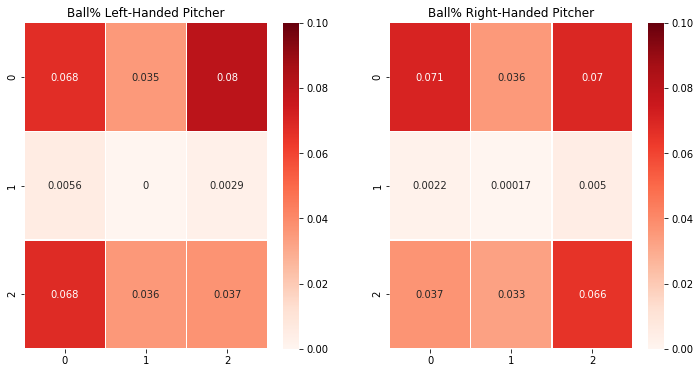

In [58]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
plot_heatmap(pitches_in_zone, ax1, handedness='L', code=['B'], vmin=0, vmax=0.1)
plot_heatmap(pitches_in_zone, ax2, handedness='R', code = ['B'], vmin=0, vmax=0.1)
ax1.title.set_text('Ball% Left-Handed Pitcher')
ax2.title.set_text('Ball% Right-Handed Pitcher')
#this shows a subtle but very interesting trend: pitches on the inside of the plate (relative to handedness) 
#are more likely to be balls!

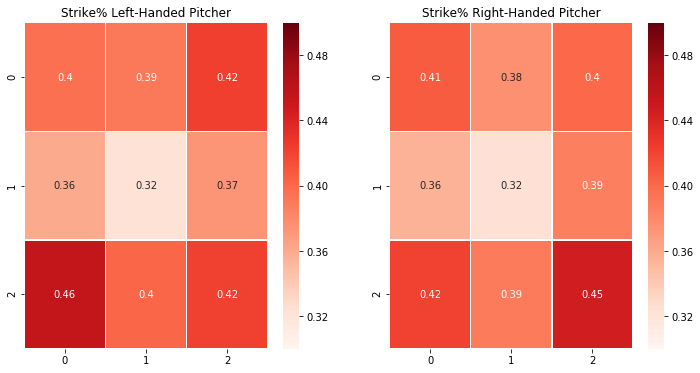

In [59]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
plot_heatmap(pitches_in_zone, ax1, handedness='L')
plot_heatmap(pitches_in_zone, ax2, handedness='R')
ax1.title.set_text('Strike% Left-Handed Pitcher')
ax2.title.set_text('Strike% Right-Handed Pitcher')
#as expected, pitches at the top and bottom and corners of the zone have a higher strike percentage.

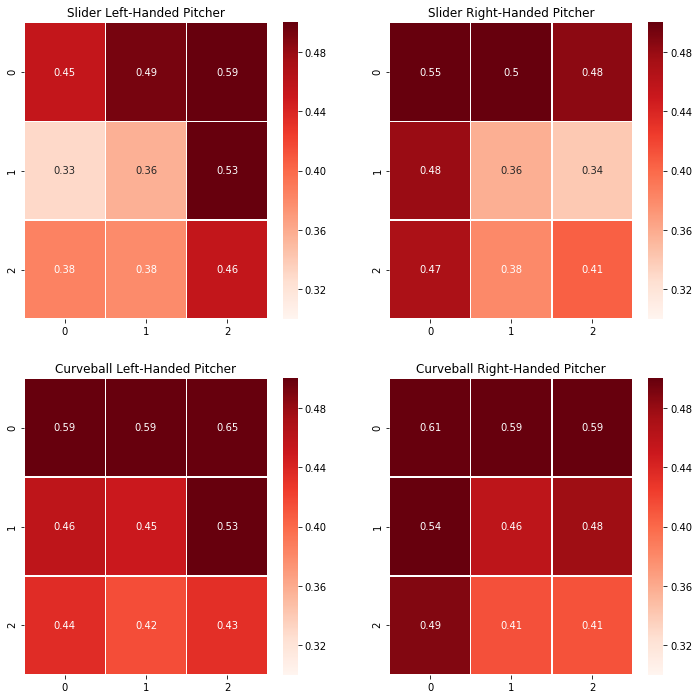

In [60]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(12,12))
plot_heatmap(pitches_in_zone, ax1, handedness='L', pitch='Slider')
plot_heatmap(pitches_in_zone, ax2, handedness='R', pitch='Slider')
plot_heatmap(pitches_in_zone, ax3, handedness='L', pitch='Curveball')
plot_heatmap(pitches_in_zone, ax4, handedness='R', pitch='Curveball')
ax1.title.set_text('Slider Left-Handed Pitcher')
ax2.title.set_text('Slider Right-Handed Pitcher')
ax3.title.set_text('Curveball Left-Handed Pitcher')
ax4.title.set_text('Curveball Right-Handed Pitcher')
#sliders thrown away the pitcher's arm-side lead to the most strikes. likewise, this is the trend for curveballs. 
#this is probably because these pitches are thrown to break out of the zone, causing pitchers to chase the pitches out of the 
#zone.

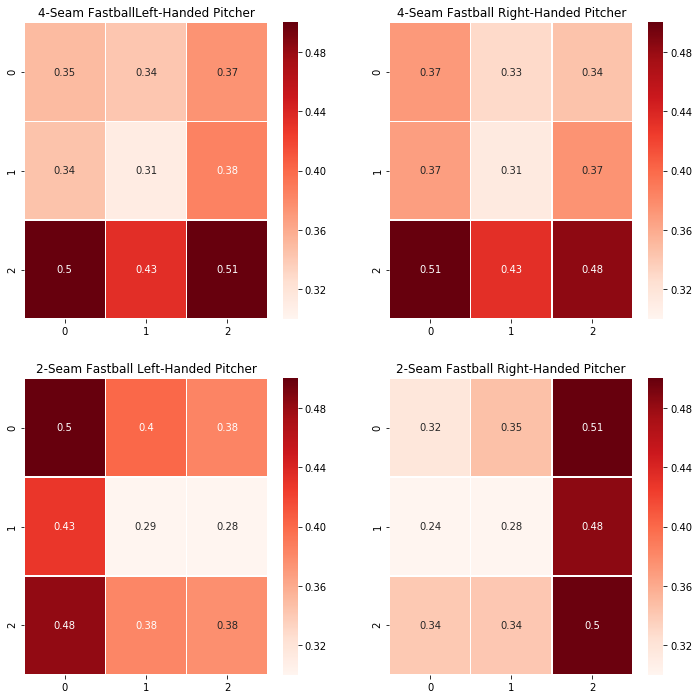

In [61]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(12,12))
plot_heatmap(pitches_in_zone, ax1, handedness='L', pitch='4-Seam Fastball')
plot_heatmap(pitches_in_zone, ax2, handedness='R', pitch='4-Seam Fastball')
plot_heatmap(pitches_in_zone, ax3, handedness='L', pitch='2-Seam Fastball')
plot_heatmap(pitches_in_zone, ax4, handedness='R', pitch='2-Seam Fastball')
ax1.title.set_text('4-Seam FastballLeft-Handed Pitcher')
ax2.title.set_text('4-Seam Fastball Right-Handed Pitcher')
ax3.title.set_text('2-Seam Fastball Left-Handed Pitcher')
ax4.title.set_text('2-Seam Fastball Right-Handed Pitcher')
#4-seam fastballs are best low in the zone, while 2-seam fastballs are best on the side to which they break. for a right hander, 
#his 2-seam would break to the right, and it would appear the throwing the pitch near to the middle and having it break to the
#inside of the plate is what generates the most strikes. 

## Investigating pitch distributions and sequences:

Here we look at the distribution of pitches at different counts of strikes and balls. Generally, pitchers behind in the count are pressured to throw fastballs since those have the highest chance of being a strike, owing to the lack of movement compared to off-speed pitches. This sets them up for failure, since throwing more fastballs later in the count is not just predictable, but easier to hit, since they are forced to throw them closer to the middle of the strikezone. 

Here, we demonstrate that left handed pitchers are less likely to throw fastballs when they are behind in the count, and this may contribute to their better performance in expected bases.

In [62]:
pitch_counts = pitches_atbats.groupby(['s_count','b_count','pitch_type']).agg({'event':'count'})

In [63]:
right = pitch_counts.groupby(['s_count','b_count']).sum().reset_index()
left = pitch_counts.reset_index()
pitch_frequencies = pd.merge(left, right, on = ['s_count','b_count'])
pitch_frequencies['frequency'] = pitch_frequencies['event_x']/pitch_frequencies['event_y']
pitch_frequencies.drop(['event_x','event_y'],axis=1,inplace=True)

In [64]:
pitch_frequencies.head()

,s_count,b_count,pitch_type,frequency
0,0.0,0.0,2-Seam Fastball,0.133070
1,0.0,0.0,4-Seam Fastball,0.387014
2,0.0,0.0,Change-up,0.072186
3,0.0,0.0,Curveball,0.098866
4,0.0,0.0,Cutter,0.050194


In [65]:
cmap = plt.get_cmap("tab20c")
colors = cmap(np.arange(8)*2)

def plot_pie(pitch_frequencies, b_count, s_count, ax):
    df = pitch_frequencies[(pitch_frequencies['s_count'] == s_count) & (pitch_frequencies['b_count'] == b_count)]
    df.plot.pie(y='frequency', ax=ax, legend=False, autopct='%1.0f%%', pctdistance=0.8, labels=list(pitch_frequencies['pitch_type'].iloc[0:8]), colors = colors)
    #ax.legend(list(pitch_frequencies['pitch_type'].iloc[0:8]))
    ax.set_title(str(s_count)+' Strikes, ' + str(b_count) +' Balls')
    ax.set_ylabel('')

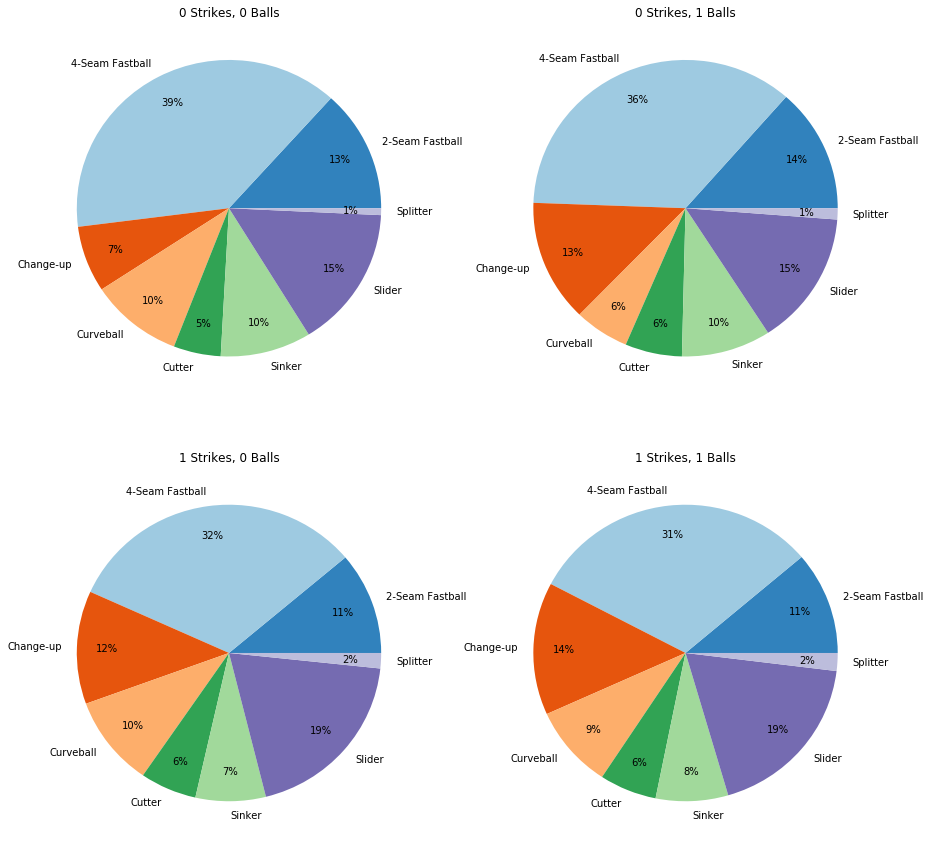

In [66]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (15,15))
plot_pie(pitch_frequencies, 0, 0, ax1)
plot_pie(pitch_frequencies, 1, 0, ax2)
plot_pie(pitch_frequencies, 0, 1, ax3)
plot_pie(pitch_frequencies, 1, 1, ax4)

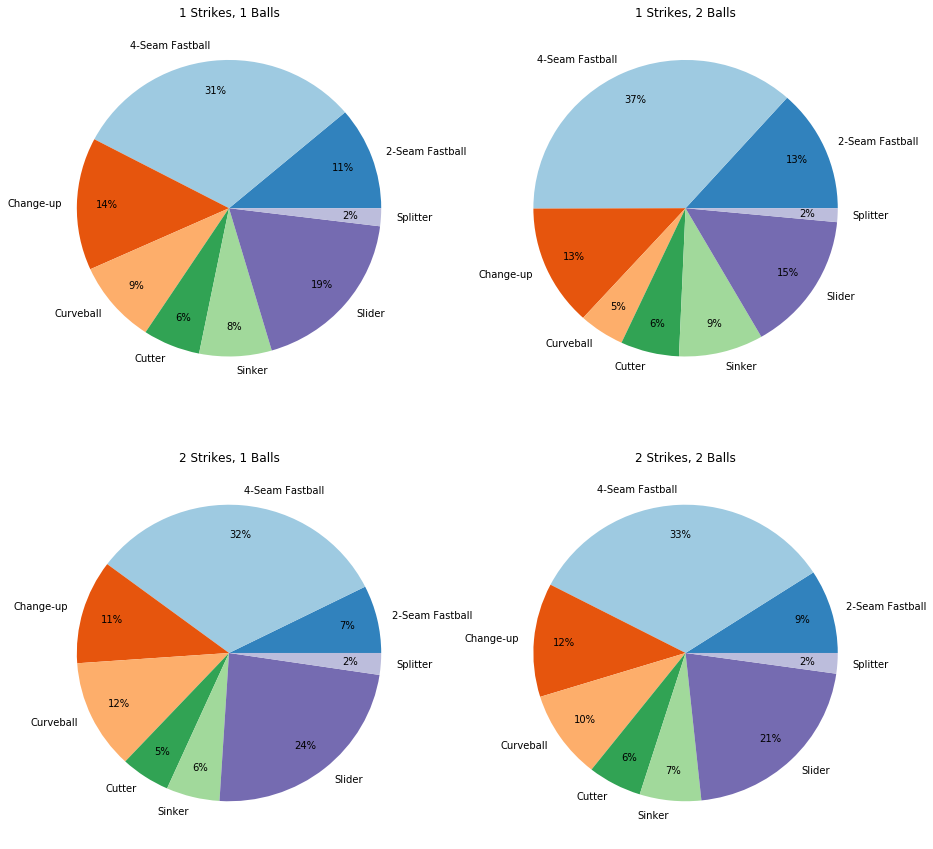

In [67]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (15,15))
plot_pie(pitch_frequencies, 1, 1, ax1)
plot_pie(pitch_frequencies, 2, 1, ax2)
plot_pie(pitch_frequencies, 1, 2, ax3)
plot_pie(pitch_frequencies, 2, 2, ax4)

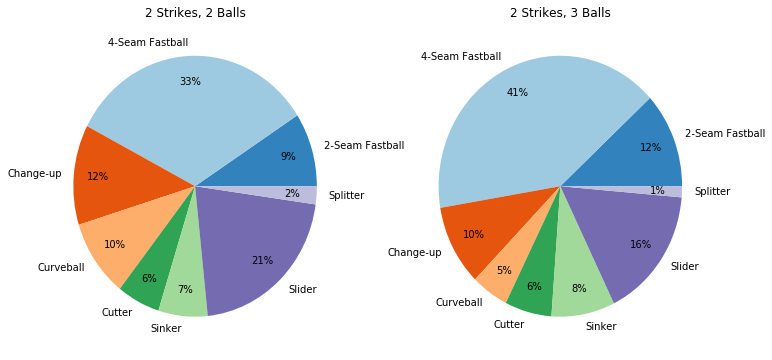

In [68]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,6))
plot_pie(pitch_frequencies, 2, 2, ax1)
plot_pie(pitch_frequencies, 3, 2, ax2)

## Left vs Right Hander Strategy?

In [69]:
pitches_atbats_L = pitches_atbats[pitches_atbats['p_throws']=='L']
pitches_atbats_R = pitches_atbats[pitches_atbats['p_throws']=='R']

In [70]:
pitch_counts_L = pitches_atbats_L.groupby(['s_count','b_count','pitch_type']).agg({'event':'count'})
pitch_counts_R = pitches_atbats_R.groupby(['s_count','b_count','pitch_type']).agg({'event':'count'})

right = pitch_counts_L.groupby(['s_count','b_count']).sum().reset_index()
left = pitch_counts_L.reset_index()
pitch_frequencies_L = pd.merge(left, right, on = ['s_count','b_count'])
pitch_frequencies_L['frequency'] = pitch_frequencies_L['event_x']/pitch_frequencies_L['event_y']
pitch_frequencies_L.drop(['event_x','event_y'],axis=1,inplace=True)

right = pitch_counts_R.groupby(['s_count','b_count']).sum().reset_index()
left = pitch_counts_R.reset_index()
pitch_frequencies_R = pd.merge(left, right, on = ['s_count','b_count'])
pitch_frequencies_R['frequency'] = pitch_frequencies_R['event_x']/pitch_frequencies_R['event_y']
pitch_frequencies_R.drop(['event_x','event_y'],axis=1,inplace=True)

Text(0.5,1,'Right: 1 Strikes, 3 Balls')

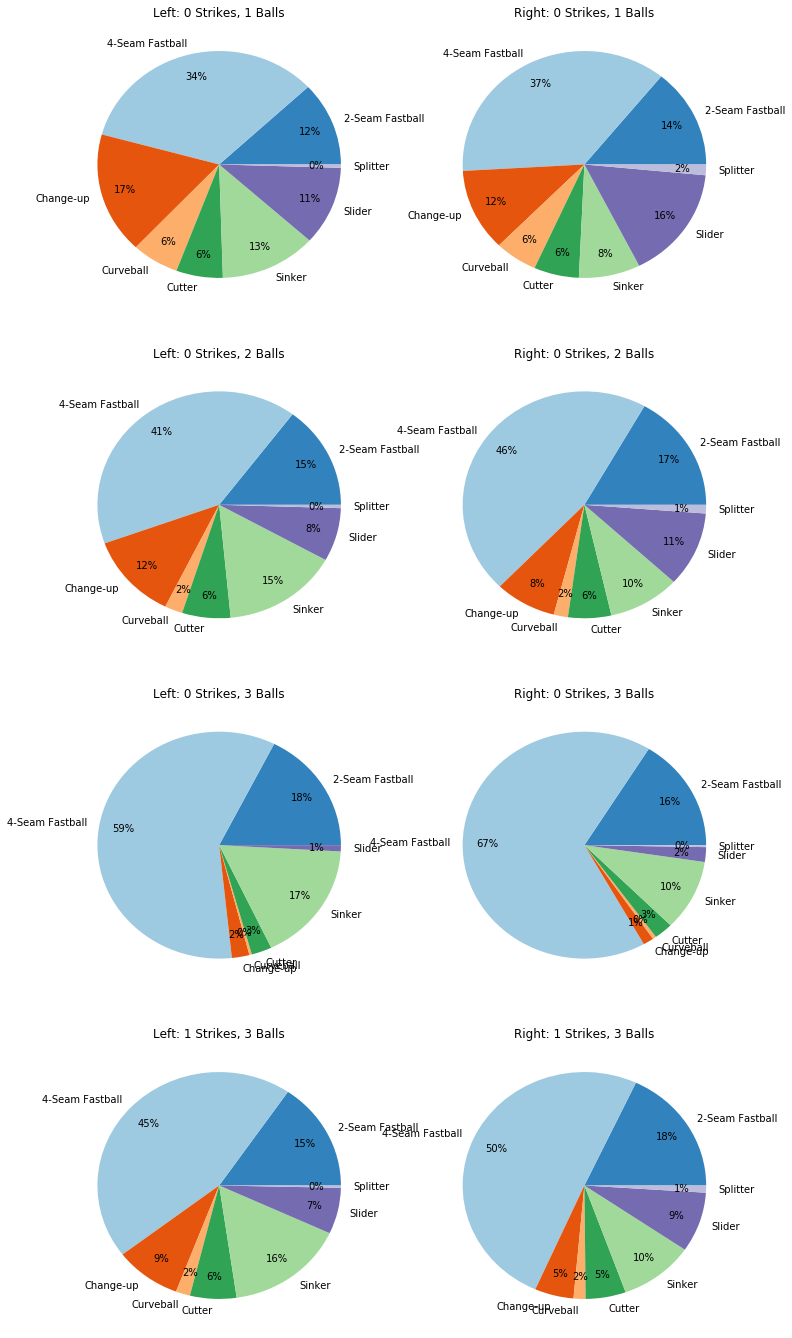

In [71]:
fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6), (ax7,ax8)) = plt.subplots(4,2, figsize = (12,24))
plot_pie(pitch_frequencies_L, 1, 0, ax1)
ax1.set_title('Left: 0 Strikes, 1 Balls')
plot_pie(pitch_frequencies_R, 1, 0, ax2)
ax2.set_title('Right: 0 Strikes, 1 Balls')

plot_pie(pitch_frequencies_L, 2, 0, ax3)
ax3.set_title('Left: 0 Strikes, 2 Balls')
plot_pie(pitch_frequencies_R, 2, 0, ax4)
ax4.set_title('Right: 0 Strikes, 2 Balls')

plot_pie(pitch_frequencies_L, 3, 0, ax5)
ax5.set_title('Left: 0 Strikes, 3 Balls')
plot_pie(pitch_frequencies_R, 3, 0, ax6)
ax6.set_title('Right: 0 Strikes, 3 Balls')

plot_pie(pitch_frequencies_L, 3, 1, ax7)
ax7.set_title('Left: 1 Strikes, 3 Balls')
plot_pie(pitch_frequencies_R, 3, 1, ax8)
ax8.set_title('Right: 1 Strikes, 3 Balls')

In all the instances above where pitchers are behind in the count, left handers throw fewer fastballs than right handers. This likely reduces their vulnerability to giving up hits when they are behind in the count.

## Building the expected bases model:

Given the structure of the data, we could have either tried to do modelling on a pitch or on an at-bat basis. If we modelled  outcomes on a pitch-basis, our model would have had to have numerous outcomes: hits, no hits, foul, etc. If we modelled on an at-bat basis, this greatly simplifies the outcomes of our model. We decided to go with this approach. 

In order to model pitches on an at-bat basis, we looked at the final pitch of each at-bat. This was useful because the end of an at-bat (this already excludes walks, situations where the runner is thrown out and the inning ends, etc) either results in an out or a hit. Because of this, we can easily restrict our outcomes to the 5 that we think matter most: no hit, single, double, triple, homerun. 

Having restricted our outcome space, we then looked to modelling pitches. Here, the goal of analysis is to calculate the average outcome of a pitch given its characteristics. In the same way that we approached 'goals added' for the NFL Dataset, here we want to see what the 'average' value of a pitch was depending on characteristics that obviously impact how hard it is to hit - this includes features like location, speed, movement and of course, pitching handedness. 

'Code' Column encodes the outcome of the at-bat. The following are the meanings of each letter:

- B - Ball

- *B - Ball in dirt

- S - Swinging Strike

- C - Called Strike

- F - Foul

- T - Foul Tip

- L - Foul Bunt

- I - Intentional Ball

- W - Swinging Strike (Blocked)

- M - Missed Bunt

- P - Pitchout

- Q - Swinging pitchout

- R - Foul pitchout

Values that only occur on last pitch of at-bat:

- X - In play, out(s)

- D - In play, no out

- E - In play, runs

In [72]:
df = pitches_atbats.groupby('ab_id').tail(n=1)

In [73]:
def consolidate_hits(row):
    if row['_1B'] == 1:
        return 1
    if row['_2B'] == 1:
        return 2
    if row['_3B'] == 1:
        return 3
    if row['_HR'] == 1:
        return 4
    
    return 0 

In [104]:
cols = ['pitcher_id','p_throws', 'px', 'pz', 'start_speed','spin_rate', 'spin_dir', 'pfx_x', 'pfx_z', 'pitch_type', '_H', '_1B', '_2B', '_3B','_HR']
df_filtered = df[df['_AB']==1]
df_filtered = df[cols]
df_filtered['outcome'] = df_filtered.apply(consolidate_hits, axis = 1)
df_filtered['pfx_x'] == [x if x>0 else -x for x in df_filtered['pfx_x']]

df_model = pd.get_dummies(df_filtered, columns=['pitch_type'], drop_first=False, prefix=None)
df_model = pd.get_dummies(df_model, columns = ['p_throws'])
df_model['outcome'] = df_model['outcome'].astype('category')

In [75]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

C:\Users\Isaac Lim\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [105]:
#X = df_model.drop(['p_throws','outcome','_H', '_1B', '_2B', '_3B', '_HR'], axis = 1)
X = df_model.drop(['pitcher_id','outcome','_H', '_1B', '_2B', '_3B', '_HR'], axis = 1)
y = df_model['outcome']
lg = LogisticRegression(multi_class='ovr').fit(X,y)
predicted_proba = lg.predict_proba(X)

In [106]:
df_filtered['expected_bases'] = np.sum(predicted_proba*np.array([0,1,2,3,4]),axis=1) #prob of outcome times cost of outcome

In [107]:
pd.DataFrame(df_filtered.groupby('pitch_type')['expected_bases'].mean())

,expected_bases
pitch_type,
2-Seam Fastball,0.355035
4-Seam Fastball,0.391228
Change-up,0.373895
Curveball,0.344432
Cutter,0.358873
Sinker,0.342016
Slider,0.343332
Splitter,0.358711


In [108]:
pd.DataFrame(df_filtered.groupby(['pitch_type','p_throws'])['expected_bases'].mean().sort_values(ascending=True))

,,expected_bases
pitch_type,p_throws,
Curveball,L,0.329697
Sinker,L,0.334076
Slider,L,0.339120
2-Seam Fastball,L,0.340369
Slider,R,0.344669
Sinker,R,0.347241
Splitter,L,0.350205
Curveball,R,0.351106
Cutter,R,0.356294


We see here that the top pitches are thrown by left-handers!

In [80]:
df_filtered.groupby(['p_throws'])['expected_bases'].sum()

p_throws
L    18555.495831
R    48630.266956
Name: expected_bases, dtype: float64

In [81]:
pd.DataFrame(df_filtered.groupby(['p_throws'])['expected_bases'].mean())

,expected_bases
p_throws,
L,0.355837
R,0.370105


In [82]:
left_eb = df_filtered[df_filtered['p_throws']=='L']['expected_bases']
right_eb = df_filtered[df_filtered['p_throws']=='R']['expected_bases']
t_test(right_eb,left_eb) #P-value of 1!!

0.0

### Multiclass Decision Tree Model

In [95]:
tree = DecisionTreeClassifier(criterion='gini').fit(X,y)
predicted_proba = tree.predict_proba(X)
df_filtered['expected_bases'] = np.sum(predicted_proba*np.array([0,1,2,3,4]),axis=1) #prob of outcome times cost of outcome

In [96]:
df_filtered.groupby('pitch_type')['expected_bases'].mean().sort_values(ascending=True)

pitch_type
Splitter           0.300133
Slider             0.321146
Curveball          0.334375
Change-up          0.355792
Cutter             0.365573
Sinker             0.382114
2-Seam Fastball    0.389256
4-Seam Fastball    0.390143
Name: expected_bases, dtype: float64

In [97]:
df_filtered.groupby(['pitch_type','p_throws'])['expected_bases'].mean().sort_values(ascending=True)

pitch_type       p_throws
Splitter         L           0.291411
                 R           0.301196
Curveball        L           0.302871
Slider           L           0.306509
                 R           0.325793
Curveball        R           0.348643
Change-up        R           0.352785
Cutter           L           0.355133
Change-up        L           0.361350
Sinker           L           0.367899
Cutter           R           0.371047
4-Seam Fastball  L           0.386527
2-Seam Fastball  L           0.387125
                 R           0.389981
4-Seam Fastball  R           0.391407
Sinker           R           0.391469
Name: expected_bases, dtype: float64

In [98]:
df_filtered.groupby(['p_throws'])['expected_bases'].mean().sort_values(ascending=True)

p_throws
L    0.358973
R    0.368885
Name: expected_bases, dtype: float64

In [99]:
left_eb = df_filtered[df_filtered['p_throws']=='L']['expected_bases']
right_eb = df_filtered[df_filtered['p_throws']=='R']['expected_bases']
t_test(right_eb,left_eb) #again, at the 5% level of significance we conclude that left expected bases < right expected bases.

0.04837108231297205

### So who is the best pitcher according to our model?

In [109]:
pitcher_eb = df_filtered.groupby('pitcher_id')['expected_bases'].mean()
pd.merge(pitchers_list, pd.DataFrame(pitcher_eb), left_on='id', right_on = 'pitcher_id').sort_values('expected_bases',ascending=True).head(25)

,id,first_name,last_name,p_throws,expected_bases
584,596027,Dillon,Maples,R,0.284285
602,657612,Tim,Hill,L,0.286931
23,502154,Zach,Britton,L,0.287670
640,458924,Jonny,Venters,L,0.288797
345,518397,Scott,Alexander,L,0.288872
606,663855,Jordan,Hicks,R,0.290317
256,519008,T.J.,McFarland,L,0.291514
137,453172,Jared,Hughes,R,0.293384
133,595014,Blake,Treinen,R,0.294511
550,607481,Aaron,Bummer,L,0.296075


Here, we see that many of our top performing pitches are left handers, again reinforcing our claim that the average expected bases on each left-handed pitch is lower than right-handed ones.